In [1]:
%matplotlib inline
import pymysql
import os
import re
import copy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from lxml import etree
import json
import time
import numpy as np

In [18]:
connection = pymysql.connect(host='127.0.0.1',
                             user='data',
                             password='data',
                             db='mag-new-160205',
                             charset='utf8mb4',
                             port=3306,
                             cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()

In [3]:
def load_result(cursor, container, name):
    for row in cursor.fetchall():
        container.append(row[name])
    return container

In [39]:
conference = 'SIGCOMM'
cursor.execute("SELECT ConferenceSeriesID FROM ConferenceSeries WHERE ShortName = '%s'" % conference)
conferenceID = cursor.fetchall()[0]['ConferenceSeriesID']

In [40]:
cursor.execute("SELECT PaperID, PaperPublishYear FROM Papers WHERE ConferenceSeriesIDMappedToVenueName = '%s'" % conferenceID)
pid_ptime_pairs = []
for row in cursor.fetchall():
    pid_ptime_pairs.append((row['PaperID'], row['PaperPublishYear']))
print (len(pid_ptime_pairs))

4421


In [41]:
co_au = {}
co_count = 0
st_coau = time.time()
for pid, ptime in pid_ptime_pairs:
    cursor.execute("SELECT AuthorID FROM PaperAuthorAffiliations WHERE PaperID = '%s'" % pid)
    aus = []
    load_result(cursor, aus, 'AuthorID')
    for au in aus:
        if au not in co_au.keys():
            co_au[au] = {}
        for cau in aus:
            if au  == cau:
                continue
            if cau not in co_au[au].keys():
                co_au[au][cau] = []
            co_au[au][cau].append(ptime)
            co_count += 1
print ("Searching Time: %.3f, Co-author item count: %d" % (time.time() - st_coau, co_count))


Searching Time: 3.047, Co-author item count: 51568


In [42]:
def export_co_author(co_dict, exdir):
    if not os.path.exists(exdir):
        os.makedirs(exdir)
    filename = os.path.join(exdir, 'link.txt')
    f = open(filename, 'w')
    for au in co_dict.keys():
        if not co_dict[au]:
            f.write(au+'\n')
            continue
        f.write(au+'\t')
        for cau in co_dict[au].keys():
            f.write(cau+'\t')
            for i in range(len(co_dict[au][cau])-1):
                f.write(str(co_dict[au][cau][i])+ ' ' + str(co_dict[au][cau][i])+'\t')
            f.write(str(co_dict[au][cau][-1]) + ' ' + str(co_dict[au][cau][-1])+'\n')
    f.close()
    print ("export %s." % filename)

In [43]:
export_co_author(co_au, 'data/coau/%s' % conference)

export data/coau/SIGCOMM/link.txt.


In [44]:
au_set = set()
for au in co_au.keys():
    au_set.add(au)
    for rau in co_au[au].keys():
        au_set.add(rau)
print ("author number: %d" % len(au_set))

author number: 8695


In [45]:
au_fos_all = [{}, {}, {}, {}]
au_fos_count = [[],[],[],[]]
for i in range(4):
    for au in au_set:
        cursor.execute("SELECT AuthorFOS.FieldOfStudyIDMappedToKeyword \
                                    FROM AuthorFOS, FieldsOfStudy WHERE \
                                    AuthorFOS.AuthorID = '%s' and FieldsOfStudy.FieldsOfStudyID = AuthorFOS.FieldOfStudyIDMappedToKeyword and \
                                    FieldsOfStudy.FieldsOfStudyLevel = 'L%d' " % (au, i))
        fos = []
        load_result(cursor, fos, 'FieldOfStudyIDMappedToKeyword')
        au_fos_all[i][au]  = fos
        au_fos_count[i].append(len(fos))

(array([ 5400.,  1366.,   681.,   432.,   315.,   198.,   149.,    87.,
           56.,    11.]),
 array([  0. ,   1.9,   3.8,   5.7,   7.6,   9.5,  11.4,  13.3,  15.2,
         17.1,  19. ]),
 <a list of 10 Patch objects>)

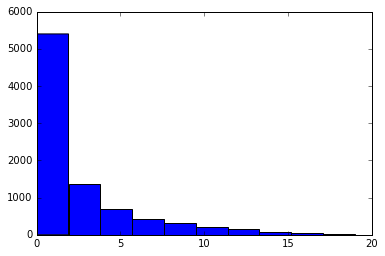

In [46]:
plt.hist(np.array(au_fos_count[0]), bins=10)

(array([  6.11500000e+03,   1.60000000e+03,   6.38000000e+02,
          1.92000000e+02,   7.70000000e+01,   4.10000000e+01,
          2.20000000e+01,   4.00000000e+00,   3.00000000e+00,
          3.00000000e+00]),
 array([   0. ,   19.6,   39.2,   58.8,   78.4,   98. ,  117.6,  137.2,
         156.8,  176.4,  196. ]),
 <a list of 10 Patch objects>)

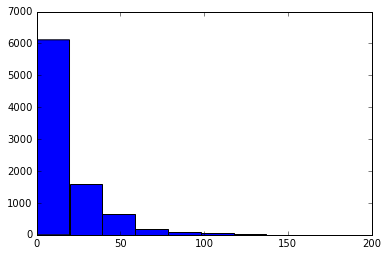

In [47]:
plt.hist(np.array(au_fos_count[1]), bins=10)

(array([  7.18600000e+03,   9.26000000e+02,   3.60000000e+02,
          1.24000000e+02,   5.60000000e+01,   2.90000000e+01,
          7.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          4.00000000e+00]),
 array([   0. ,   48.3,   96.6,  144.9,  193.2,  241.5,  289.8,  338.1,
         386.4,  434.7,  483. ]),
 <a list of 10 Patch objects>)

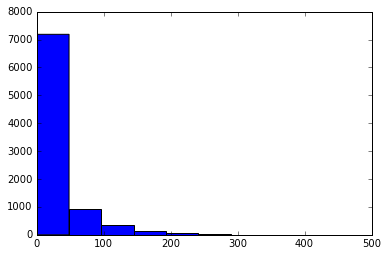

In [48]:
plt.hist(np.array(au_fos_count[2]), bins=10)

(array([  7.95800000e+03,   5.38000000e+02,   1.17000000e+02,
          4.50000000e+01,   2.20000000e+01,   8.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          4.00000000e+00]),
 array([    0. ,   702.3,  1404.6,  2106.9,  2809.2,  3511.5,  4213.8,
         4916.1,  5618.4,  6320.7,  7023. ]),
 <a list of 10 Patch objects>)

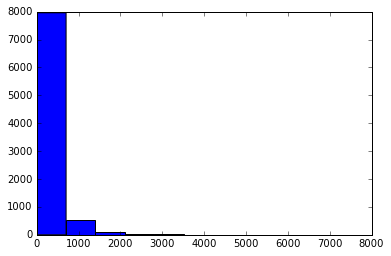

In [49]:
plt.hist(np.array(au_fos_count[3]), bins=10)

In [50]:
def export_fos(fos_dicts, exdir):
    if not os.path.exists(exdir):
        os.makedirs(exdir)
    for i in range(4):
        filename = os.path.join(exdir, 'fos_L%d.txt' % i)
        f = open(filename, 'w')
        count = 0
        for au in fos_dicts[i].keys():
            if len(fos_dicts[i][au]) == 0:
                f.write(au+'\n')
                continue
            f.write(au+'\t')
            for j in range(len(fos_dicts[i][au])-1):
                f.write(fos_dicts[i][au][j]+' ')
            f.write(fos_dicts[i][au][-1]+'\n')
            count += len(fos_dicts[i][au])
        f.close()
        print ("export %s: %d fos" % (filename, count))

In [51]:
export_fos(au_fos_all, 'data/cite/%s' % conference)

export data/cite/SIGCOMM/fos_L0.txt: 19546 fos
export data/cite/SIGCOMM/fos_L1.txt: 135268 fos
export data/cite/SIGCOMM/fos_L2.txt: 219054 fos
export data/cite/SIGCOMM/fos_L3.txt: 1895928 fos


In [55]:
fos_au_all = [{}, {}, {}, {}]
fos_au_count = [[], [], [], []]
for i in range(4):
    for au in au_fos_all[i].keys():
        for fos in au_fos_all[i][au]:
            if (fos not in fos_au_all[i].keys()):
                fos_au_all[i][fos] = set()
            fos_au_all[i][fos].add(au)
    for fos in fos_au_all[i].keys():
            setlen = len(fos_au_all[i][fos])
            fos_au_count[i].append(setlen)

(array([ 5.,  6.,  1.,  5.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   36. ,   456.2,   876.4,  1296.6,  1716.8,  2137. ,  2557.2,
         2977.4,  3397.6,  3817.8,  4238. ]),
 <a list of 10 Patch objects>)

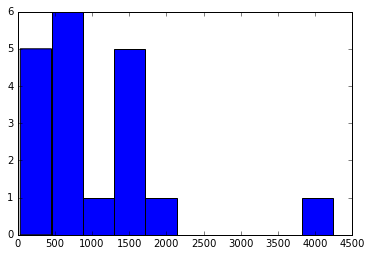

In [56]:
plt.hist(np.array(fos_au_count[0]), bins=10)

(array([ 222.,   21.,    7.,    7.,    6.,    4.,    6.,    1.,    0.,    1.]),
 array([  1.00000000e+00,   6.21000000e+02,   1.24100000e+03,
          1.86100000e+03,   2.48100000e+03,   3.10100000e+03,
          3.72100000e+03,   4.34100000e+03,   4.96100000e+03,
          5.58100000e+03,   6.20100000e+03]),
 <a list of 10 Patch objects>)

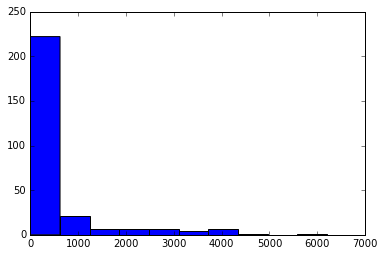

In [57]:
plt.hist(np.array(fos_au_count[1]), bins=10)

(array([ 1017.,    59.,    27.,    27.,    11.,     7.,     6.,     3.,
            0.,     5.]),
 array([  1.00000000e+00,   3.88300000e+02,   7.75600000e+02,
          1.16290000e+03,   1.55020000e+03,   1.93750000e+03,
          2.32480000e+03,   2.71210000e+03,   3.09940000e+03,
          3.48670000e+03,   3.87400000e+03]),
 <a list of 10 Patch objects>)

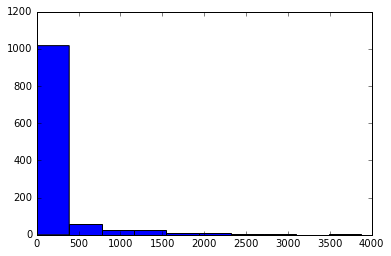

In [58]:
plt.hist(np.array(fos_au_count[2]), bins=10)

(array([  2.24920000e+04,   4.50000000e+02,   1.60000000e+02,
          7.90000000e+01,   4.50000000e+01,   1.30000000e+01,
          1.90000000e+01,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   5.60400000e+02,   1.11980000e+03,
          1.67920000e+03,   2.23860000e+03,   2.79800000e+03,
          3.35740000e+03,   3.91680000e+03,   4.47620000e+03,
          5.03560000e+03,   5.59500000e+03]),
 <a list of 10 Patch objects>)

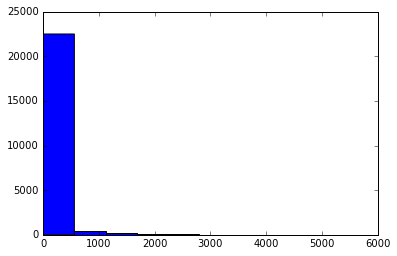

In [59]:
plt.hist(np.array(fos_au_count[3]), bins=10)

In [52]:
def com_export_fos(fos_au_dicts, exdir):
    if not os.path.exists(exdir):
        os.makedirs(exdir)
    for i in range(4):
        filename = os.path.join(exdir, 'c_fos_L%d.txt' % i)
        f = open(filename, 'w')
        for fos in fos_au_dicts[i].keys():
            setlen = len(fos_au_dicts[i][fos])
            if  setlen == 0:
                f.write(fos+'\n')
                continue
            f.write(fos+'\t')
            for j, au in enumerate(fos_au_dicts[i][fos]):
                f.write(au)
                if (j < setlen - 1):
                    f.write(' ')
            f.write('\n')

SyntaxError: invalid syntax (<ipython-input-52-dbe2464f9e52>, line 10)